<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/assignment_3_date__6_21_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize(224),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])  # ImageNet stats
])

mnist_test = datasets.MNIST('.', train=False, download=True, transform=transform)
mnist_train = datasets.MNIST('.', train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.2kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.16MB/s]


In [2]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import models

# Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC

# DataLoader for small test subset (e.g., 500 images)
test_loader = DataLoader(Subset(mnist_test, range(500)), batch_size=50)

features_pre = []
labels = []
with torch.no_grad():
    for imgs, labs in test_loader:
        feats = feature_extractor(imgs).view(imgs.size(0), -1)
        features_pre.append(feats.numpy())
        labels.extend(labs.numpy())
import numpy as np
features_pre = np.vstack(features_pre)
labels = np.array(labels)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [3]:
import torch.nn as nn

num_classes = 10
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)  # 10 output neurons

In [4]:
import torch.optim as optim

# Use your mnist_train DataLoader (already preprocessed)
train_loader = DataLoader(Subset(mnist_train, range(1000)), batch_size=50, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

resnet.train()  # Set model to training mode

for epoch in range(3):  # Train for 3 epochs
    running_loss = 0.0
    for imgs, labs in train_loader:
        optimizer.zero_grad()         # Clear gradients
        outputs = resnet(imgs)        # Forward pass
        loss = criterion(outputs, labs)  # Compute loss
        loss.backward()               # Backpropagate
        optimizer.step()              # Update weights
        running_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}")


Epoch 1: Loss = 0.8837
Epoch 2: Loss = 0.1080
Epoch 3: Loss = 0.0329


In [5]:
# Set model to evaluation mode
resnet.eval()

# Remove the last classifier layer to get feature vectors
feature_extractor2 = torch.nn.Sequential(*list(resnet.children())[:-1])

features_post = []
with torch.no_grad():
    for imgs, _ in test_loader:    # Use the same test_loader as before (500 images)
        feats = feature_extractor2(imgs).view(imgs.size(0), -1)
        features_post.append(feats.numpy())
features_post = np.vstack(features_post)   # Shape: (500, feature_dim)


In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt


In [29]:
def plot2D(X, y, title, i):
    plt.figure(figsize=(6,6))
    plt.subplot(2,1,i)
    scatter = plt.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=10, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, ticks=range(10))

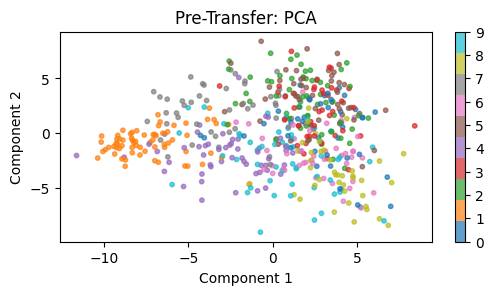

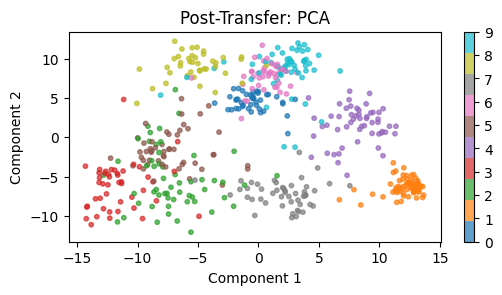

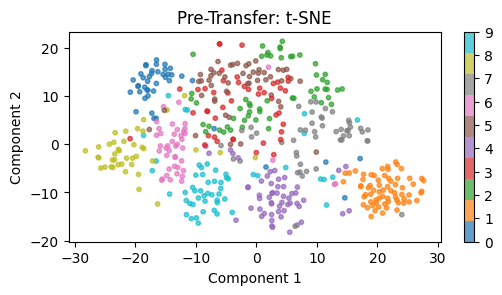

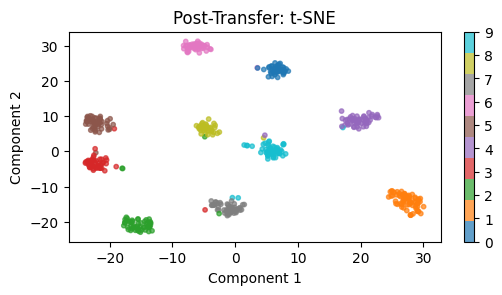

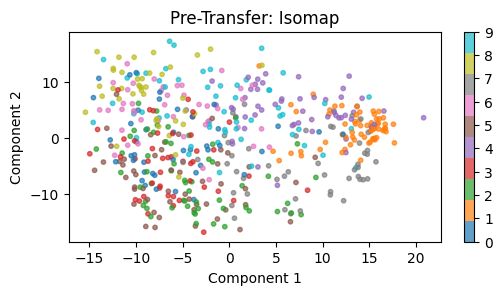

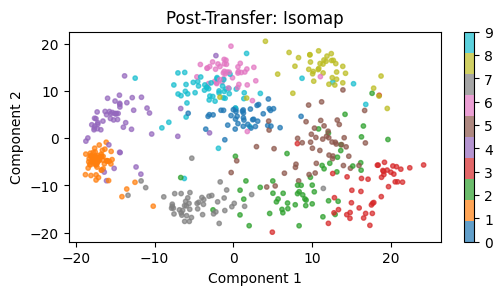

In [27]:
# PCA
pca = PCA(n_components=2)
plot2D(pca.fit_transform(features_pre), labels,  'Pre-Transfer: PCA', 1)
plot2D(pca.fit_transform(features_post), labels, 'Post-Transfer: PCA', 2)
plt.show()
# t-SNE
tsne = TSNE(n_components=2, random_state=0)
plot2D(tsne.fit_transform(features_pre), labels,  'Pre-Transfer: t-SNE' , 1)
plot2D(tsne.fit_transform(features_post), labels, 'Post-Transfer: t-SNE' ,2)
plt.show()
# Isomap
isomap = Isomap(n_neighbors=200, n_components=2)
plot2D(isomap.fit_transform(features_pre), labels,  'Pre-Transfer: Isomap', 1)
plot2D(isomap.fit_transform(features_post), labels, 'Post-Transfer: Isomap', 2)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


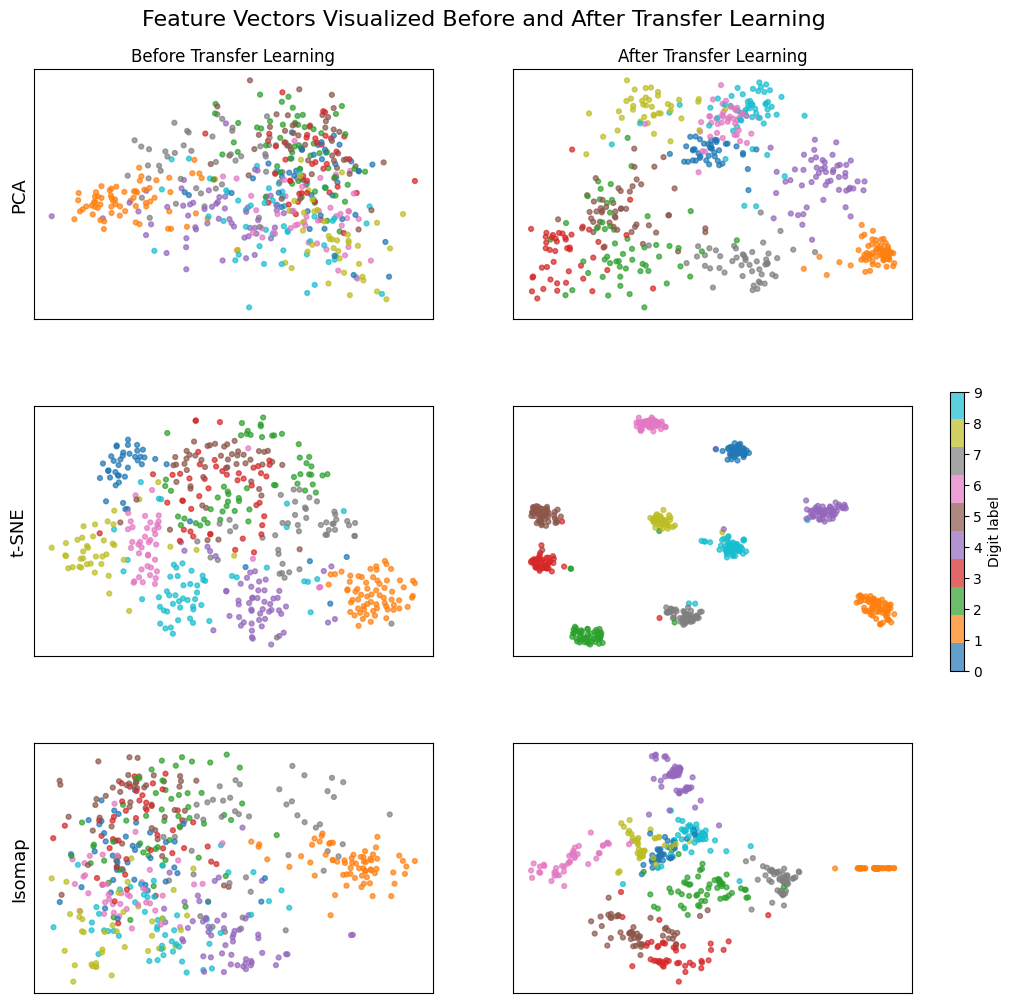

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# Put your feature arrays and labels here
# features_pre: (n_samples, feature_dim), BEFORE transfer learning
# features_post: (n_samples, feature_dim), AFTER transfer learning
# labels: (n_samples, ) digit labels

methods = [
    ("PCA",    PCA(n_components=2)),
    ("t-SNE",  TSNE(n_components=2, random_state=0)),
    ("Isomap", Isomap(n_neighbors=10, n_components=2))
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.35)

for row, (name, reducer) in enumerate(methods):
    # Fit and transform for before and after
    X_pre  = reducer.fit_transform(features_pre)
    X_post = reducer.fit_transform(features_post)

    # Plot "before"
    ax = axes[row, 0]
    scatter = ax.scatter(X_pre[:, 0], X_pre[:, 1], c=labels, cmap="tab10", s=12, alpha=0.7)
    if row == 0:
        ax.set_title("Before Transfer Learning")
    ax.set_ylabel(name, fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot "after"
    ax = axes[row, 1]
    scatter = ax.scatter(X_post[:, 0], X_post[:, 1], c=labels, cmap="tab10", s=12, alpha=0.7)
    if row == 0:
        ax.set_title("After Transfer Learning")
    ax.set_xticks([])
    ax.set_yticks([])

# Put a colorbar on the side
fig.colorbar(scatter, ax=axes, orientation="vertical", fraction=0.015, pad=0.04, label='Digit label')

plt.suptitle("Feature Vectors Visualized Before and After Transfer Learning", fontsize=16, y=0.93)
plt.show()
